In [5]:
# Import the required libraries

import torch
import os
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.nn.functional import interpolate
import torch.nn as nn
import math
import numpy as np
from natsort import natsorted
from PIL import Image
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

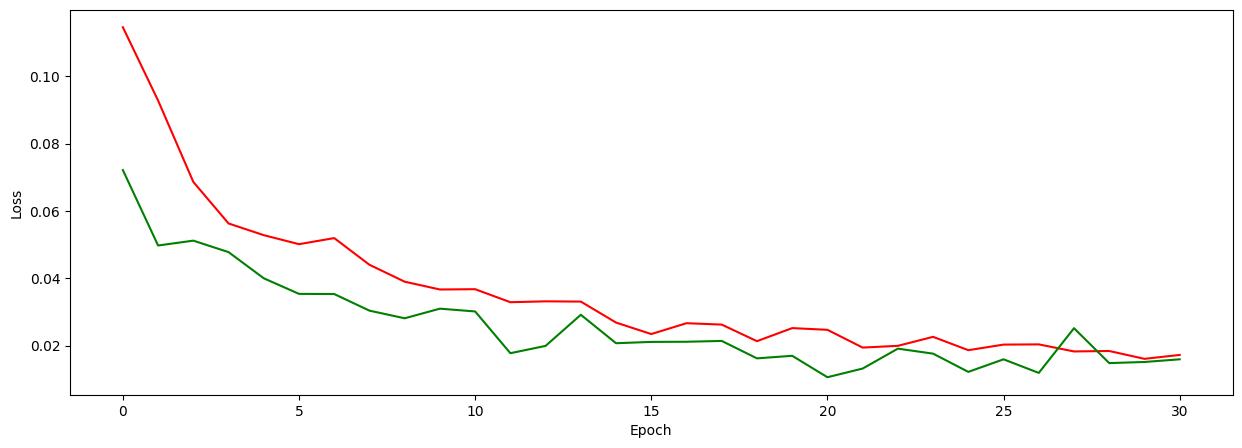

In [10]:
# Create training graph
run_name      = "run3"
train_log_dir = f"results/{run_name}/train_losses.txt"
val_log_dir   = f"results/{run_name}/val_losses.txt"

with open(train_log_dir, "r") as file:
    train_losses        = file.readlines()
    train_batch_count   = float(train_losses[0])
    train_losses        = [float(line.split(",")[1].split(":")[1].strip())/train_batch_count for line in train_losses[1:]]

with open(val_log_dir, "r") as file:
    val_losses      = file.readlines()
    val_batch_count = float(val_losses[0])
    val_losses      = [float(line.split(",")[1].split(":")[1].strip())/val_batch_count for line in val_losses[1:]]


#plt.title("Training curve")
figure = plt.figure(figsize=(15,5))
plt.plot(range(len(train_losses)),train_losses,'r')
plt.plot(range(len(val_losses)),val_losses,'g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [11]:
# Assign loss values
run_name    = "run2"
all_images  = os.listdir(f"Results/{run_name}")
gt_labels   = natsorted([image_dir for image_dir in all_images if image_dir[:2] == "GT"])
pred_labels = natsorted([image_dir for image_dir in all_images if image_dir[:3] == "Out"])

loss_func = torch.nn.L1Loss()
convert_tensor = transforms.ToTensor()

with open("file_to_category.pkl", "rb") as file:
    file_to_category = pickle.load(file)

category_losses = {}
file_name_to_loss = {}
green_channel_losses = {}

for gt, pred in tqdm(zip(gt_labels, pred_labels)):

    image_name = gt[3:]

    # Load those images
    gt_image   = Image.open(f'Results/{run_name}/{gt}').convert("RGB") 
    pred_image = Image.open(f'Results/{run_name}/{pred}').convert("RGB")
    gt_image, pred_image = convert_tensor(gt_image), convert_tensor(pred_image)

    # Find out what category they belong to
    category = file_to_category[image_name]

    # Compare the loss between them
    loss = loss_func(gt_image, pred_image)

    # Get lossi n just the green channel
    green_loss = loss_func(gt_image[1], pred_image[1])

    # Save the loss statistics
    file_name_to_loss[image_name] = loss.item()
    green_channel_losses[image_name] = green_loss.item()


    if category in category_losses:
        category_losses[category] += [loss.item()]
    else:
        category_losses[category]  = [loss.item()]

total_loss = sum(list(file_name_to_loss.values()))
mean_loss  = np.mean(list(file_name_to_loss.values()))
best_loss  = min(list(file_name_to_loss.values()))
worst_loss = max(list(file_name_to_loss.values())) 

print("Dataset based statistics")
print(f"Total Loss: {total_loss}")
print(f"Mean Loss: {mean_loss}")
print(f"Best Loss: {best_loss}")
print(f"Worst Loss: {worst_loss}")

print("")
print("Green Channel Losses")
mean_loss  = np.mean(list(green_channel_losses.values()))
print(mean_loss)

print(" ")
print("Class based statistics:")
for key in category_losses.keys():
    category_losses[key] = np.mean(category_losses[key])
    print(key, category_losses[key])

print(f"Mean loss: {np.mean(list(category_losses.values()))}")
print(f"STD of losses: {np.std(list(category_losses.values()))}")
print(f"Median loss: {np.median(list(category_losses.values()))}")


320it [00:00, 646.33it/s]

Dataset based statistics
Total Loss: 100.54800138995051
Mean Loss: 0.3142125043435954
Best Loss: 0.033900924026966095
Worst Loss: 0.7773327827453613

Green Channel Losses
0.5396110065747053
 
Class based statistics:
airport_terminal 0.29425007653863805
kitchen 0.3504002375528216
populated 0.33555842426262406
conference_room 0.34316700714684667
amusement_park 0.43551358828941983
living room 0.28145793322473767
golf_course 0.3365791136255631
big 0.29098778040636153
badlands 0.22721977117988798
public-entertainment 0.31115874577136265
living_room 0.2998034978285432
isolated 0.28095272972303276
mountain 0.315532990864345
house 0.24749374886353812
small 0.33956105556142957
pasture 0.3749736868776381
skyscraper 0.3113906182348728
work-home 0.2415035843849182
playground 0.33545343790735516
Mean loss: 0.31331358043389135
STD of losses: 0.047703803020101194
Median loss: 0.3113906182348728


In [7]:
# Get an ordering of the best and worst images
best_image_scores   = sorted(file_name_to_loss.items(), key = lambda x:x[1], reverse=False)
worst_image_scores  = sorted(file_name_to_loss.items(), key = lambda x:x[1], reverse=True)

image: sun_bkckogsndapeoiyj.jpg loss: 0.033900924026966095
image: sun_bntjgmywduitzqsd.jpg loss: 0.0395578034222126
image: sun_bikgkfqegrsltekf.jpg loss: 0.041971683502197266
image: sun_blegzvkseullxigg.jpg loss: 0.04643451049923897
image: sun_bbjpwjobjhuarxzr.jpg loss: 0.04652849957346916
image: sun_avuqfmqnnacpugwc.jpg loss: 0.048118364065885544
image: sun_bzbfrerjbynsukdf.jpg loss: 0.05775146558880806
image: sun_bosozoenihjtekxa.jpg loss: 0.05808249115943909
image: sun_baktujtxgdfjhybp.jpg loss: 0.06046988442540169


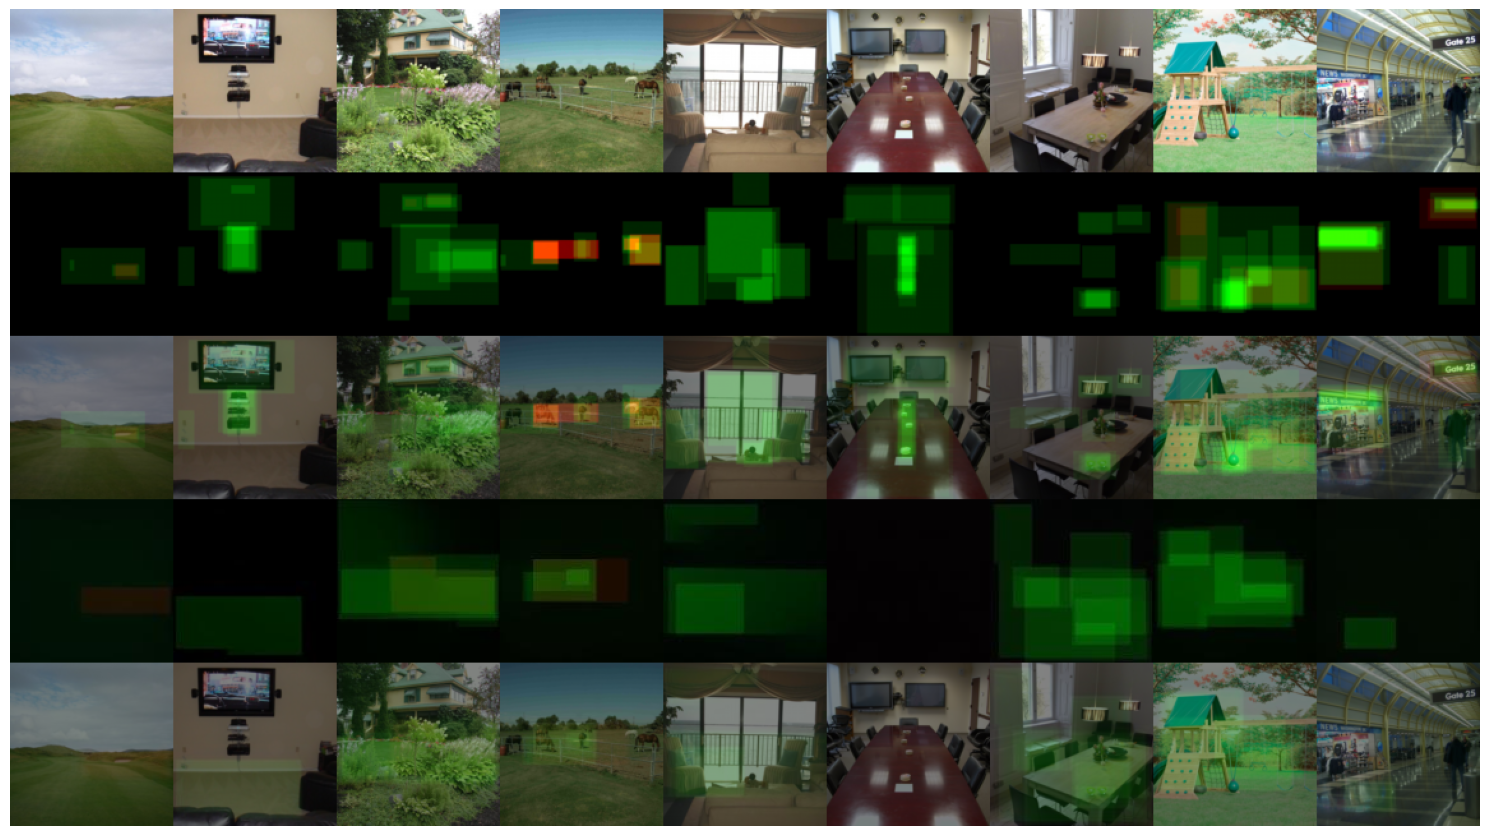

In [8]:
# Display boilerplate
figure = plt.figure(figsize=(15,15))
cols, rows = 9, 1

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(128, antialias=True),
    transforms.Normalize(0.5,0.5)
])

# Show the best
for i in range(cols):
    
    image_path   = best_image_scores[i][0]
    print(f"image: {best_image_scores[i][0]} loss: {best_image_scores[i][1]}")
    image        = image_transforms(Image.open(f"../VISCHEMA_PLUS/images/{image_path}").convert("RGB"))
    label        = image_transforms(Image.open(f"../VISCHEMA_PLUS/vms/{image_path}").convert("RGB"))
    output       = image_transforms(Image.open(f"Results/{run_name}/Out_{image_path}").convert("RGB"))

    image, label, output = image[None, :], label[None, :], output[None, :]

    ideal        = torch.add(image, label)/2
    output_cat   = torch.add(image, output)/2

    if i == 0:
        display = torch.cat([
            image.to("cpu"), 
            label.to("cpu"), 
            ideal.to("cpu").detach(), 
            output.to("cpu").detach(), 
            output_cat.to("cpu").detach()
            ], dim=2)
    else:

        display = torch.cat([
            display, 
            torch.cat([
                image.to("cpu"), 
                label.to("cpu"), 
                ideal.to("cpu").detach(), 
                output.to("cpu").detach(), 
                output_cat.to("cpu").detach()
                ], dim=2)
            ], dim = 3)

display = ((display +1 ) /2).clip(0,1)        
plt.axis("off")
plt.imshow(display[0].squeeze().permute(1, 2, 0)) 
plt.tight_layout()
plt.show()

image: sun_awrxnfdfzyznnbtd.jpg loss: 0.7773327827453613
image: sun_btunyzssqeynsifi.jpg loss: 0.7516741752624512
image: sun_amyesogulgzshsqv.jpg loss: 0.7451980710029602
image: sun_bvfurauxmvdtyvgf.jpg loss: 0.7413118481636047
image: sun_akztvatsuoznrbzt.jpg loss: 0.7361060976982117
image: sun_ahdoavtbmzlbpsyw.jpg loss: 0.731519877910614
image: sun_bcanxwxacwqfxkbf.jpg loss: 0.6974680423736572
image: sun_aybpvlbbsnxxwjmm.jpg loss: 0.6879901885986328
image: sun_beywxwpgsancacqo.jpg loss: 0.6862395405769348


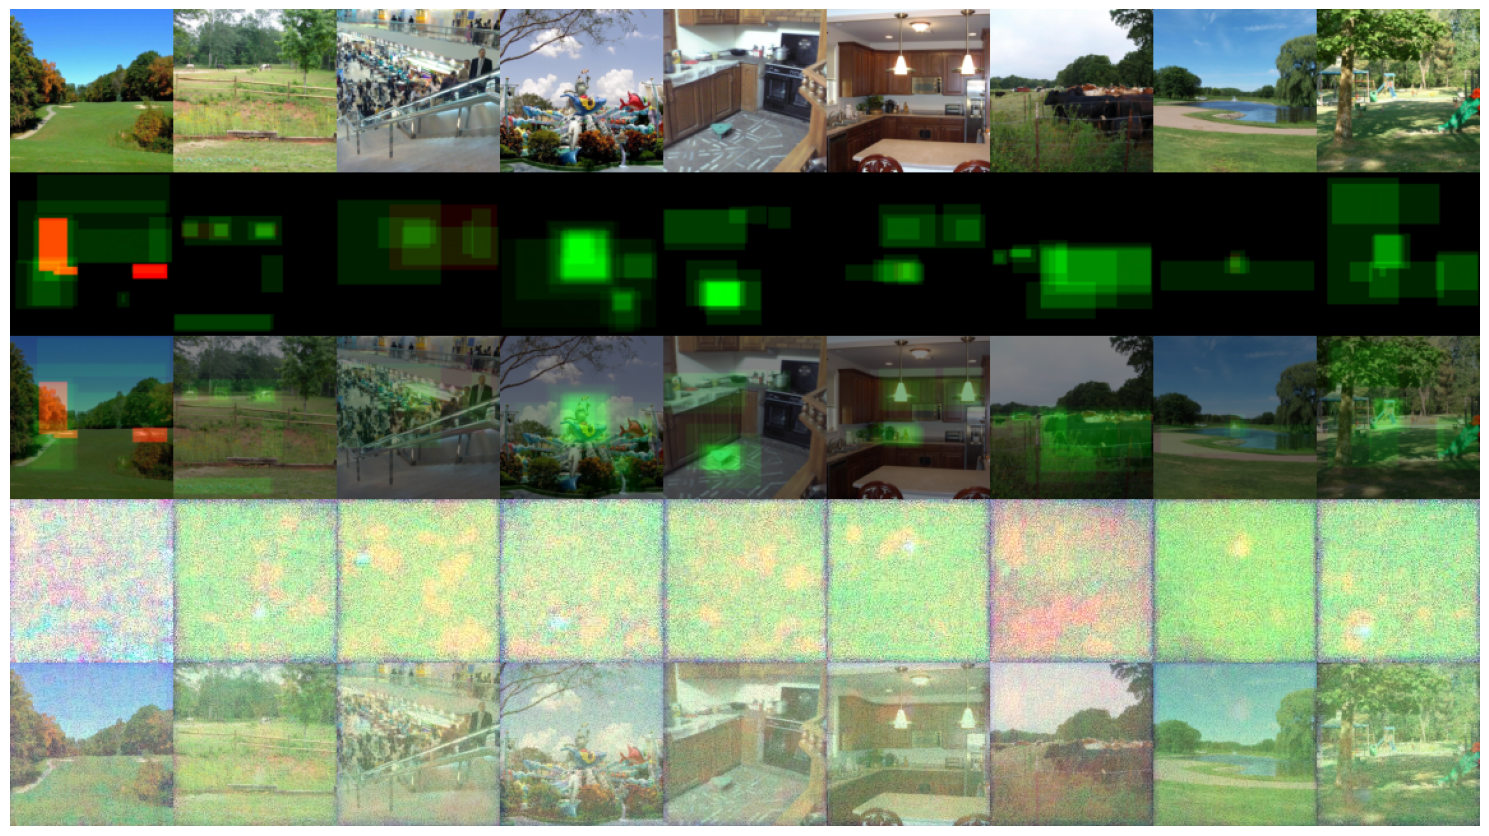

In [9]:
# Display boilerplate
figure = plt.figure(figsize=(15,15))
cols, rows = 9, 1

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(128, antialias=True),
    transforms.Normalize(0.5,0.5)
])


# Show the worst
for i in range(cols):
    
    image_path   = worst_image_scores[i][0]
    print(f"image: {worst_image_scores[i][0]} loss: {worst_image_scores[i][1]}")
    image        = image_transforms(Image.open(f"../VISCHEMA_PLUS/images/{image_path}").convert("RGB"))
    label        = image_transforms(Image.open(f"../VISCHEMA_PLUS/vms/{image_path}").convert("RGB"))
    output       = image_transforms(Image.open(f"Results/{run_name}/Out_{image_path}").convert("RGB"))

    image, label, output = image[None, :], label[None, :], output[None, :]

    ideal        = torch.add(image, label)/2
    output_cat   = torch.add(image, output)/2

    if i == 0:
        display = torch.cat([
            image.to("cpu"), 
            label.to("cpu"), 
            ideal.to("cpu").detach(), 
            output.to("cpu").detach(), 
            output_cat.to("cpu").detach()
            ], dim=2)
    else:

        display = torch.cat([
            display, 
            torch.cat([
                image.to("cpu"), 
                label.to("cpu"), 
                ideal.to("cpu").detach(), 
                output.to("cpu").detach(), 
                output_cat.to("cpu").detach()
                ], dim=2)
            ], dim = 3)

display = ((display +1 ) /2).clip(0,1)        
plt.axis("off")
plt.imshow(display[0].squeeze().permute(1, 2, 0)) 
plt.tight_layout()
plt.show()